In [ ]:
# !pip install --user statsmodels

In [221]:
import os

import numpy as np
import pandas as pd

RAW_DATA_PATH = './raw_data/'
DATA_PATH = './data'
VAL_SIZE = 0.1
RANDOM_STATE = 42

In [14]:
test_users = pd.read_csv(os.path.join(RAW_DATA_PATH, 'test_users.csv'))

In [2]:
data_clicks = pd.read_hdf(os.path.join(DATA_PATH, 'step0_clicks.h5'), index=None, key='step0')
data_likes = pd.read_hdf(os.path.join(DATA_PATH, 'step0_likes.h5'), index=None, key='step0')
data_shares = pd.read_hdf(os.path.join(DATA_PATH, 'step0_shares.h5'), index=None, key='step0')

# Первичный Train/Val split (по времени)

In [5]:
clicks_day_percentage = data_clicks[['day']]
clicks_day_percentage.loc[:, 'percentage'] = (
    clicks_day_percentage['day'].rank() / clicks_day_percentage['day'].rank().max()
)

def split_train_val(df, clicks_day_percentage, val_size):
    train_days = clicks_day_percentage[clicks_day_percentage['percentage'] < (1 - val_size)]['day'].unique()
    train = df[df['day'].isin(train_days)]
    
    val_days = clicks_day_percentage[clicks_day_percentage['percentage'] >= (1 - val_size)]['day'].unique()
    val = df[df['day'].isin(val_days)]
    
    print(train.shape, val.shape)
    print()
    
    return train, val

In [6]:
train_clicks, val_clicks = split_train_val(data_clicks, clicks_day_percentage, val_size=VAL_SIZE)
train_likes, _ = split_train_val(data_likes, clicks_day_percentage, val_size=VAL_SIZE)
train_shares, _ = split_train_val(data_shares, clicks_day_percentage, val_size=VAL_SIZE)

(2110342, 5) (250520, 5)

(272389, 5) (36033, 5)

(44156, 5) (3711, 5)



##### Фильтруем пользователей из валидации

In [13]:
train_users = (
    set(train_clicks['user_id'].unique().tolist())
    | set(train_likes['user_id'].unique().tolist())
    | set(train_shares['user_id'].unique().tolist())
)

val_clicks_filtered = val_clicks[val_clicks['user_id'].isin(train_users)]
val_clicks_filtered.shape

(135692, 5)

In [407]:
val_clicks_filtered.to_hdf(os.path.join(DATA_PATH, 'step1_val_clicks.h5'), index=None, key='step1')
val_clicks = val_clicks_filtered

In [455]:
train_clicks.to_hdf(os.path.join(DATA_PATH, 'step1_train_clicks.h5'), index=None, key='step1')
train_likes.to_hdf(os.path.join(DATA_PATH, 'step1_train_likes.h5'), index=None, key='step1')
train_shares.to_hdf(os.path.join(DATA_PATH, 'step1_train_shares.h5'), index=None, key='step1')

# Выбираем пользователей для валидации

In [408]:
test_clicks = test_users.merge(data_clicks, on='user_id', how='left')
test_clicks.head()

,user_id,picture_id,day,user_day_ordinal,pseudo_ts
0,103,1015062,2019-02-01,0,2019-02-01 00:00:00
1,103,643285,2019-02-01,1,2019-02-01 03:00:00
2,103,988094,2019-02-01,2,2019-02-01 06:00:00
3,103,664834,2019-02-01,3,2019-02-01 09:00:00
4,103,664834,2019-02-01,4,2019-02-01 12:00:00


In [409]:
test_clicks_cnt = (
    test_clicks
    .groupby('user_id')['picture_id']
    .agg(['count'])
    .reset_index()
    .rename(columns={'count': 'pictures_cnt'})
)
test_clicks_cnt['pictures_cnt'] = test_clicks_cnt['pictures_cnt'] / test_clicks_cnt['pictures_cnt'].sum()

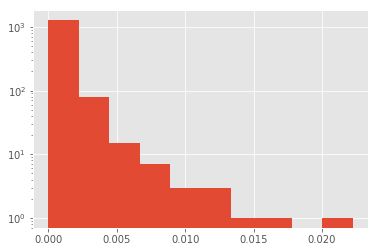

In [410]:
%matplotlib inline
test_clicks_cnt['pictures_cnt'].hist(log=True)

### Подбираем подходящее распределение

In [411]:
%matplotlib inline


from tqdm.auto import tqdm

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in tqdm(DISTRIBUTIONS):
        print(distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


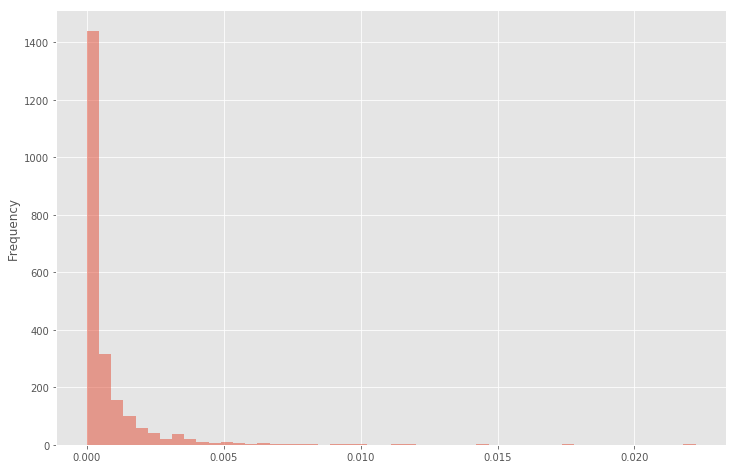

In [412]:
# Load data from statsmodels datasets
# data = pd.Series(sm.datasets.elnino.load_pandas().data.set_index('YEAR').values.ravel())
data = test_clicks_cnt['pictures_cnt']

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5) #, color=plt.rcParams['axes.color_cycle'][1])
# Save plot limits
dataYLim = ax.get_ylim()

In [413]:
# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)

In [414]:
best_dist = getattr(st, best_fit_name)
best_dist

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0, 0.5, 'Users count')

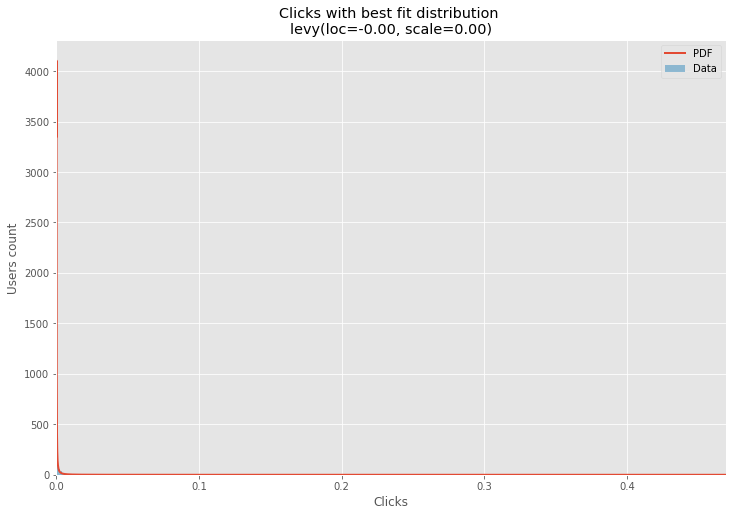

In [415]:
# Update plots
ax.set_ylim(dataYLim)
ax.set_title('All Fitted Distributions')
ax.set_xlabel('Clicks')
ax.set_ylabel('Users count')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
# plt.xscale('log')
# plt.yscale('log')
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title('Clicks with best fit distribution \n' + dist_str)
ax.set_xlabel('Clicks')
ax.set_ylabel('Users count')

In [416]:
arg = best_fit_params[:-2]
loc = best_fit_params[-2]
scale = best_fit_params[-1]

from functools import partial

bpdf = partial(best_dist.pdf, *arg, loc=loc, scale=scale)
bpdf(1)

0.003425465358197081

### Фильтруем пользователей

In [417]:
val_clicks_cnt = (
    val_clicks
    .groupby('user_id')['picture_id']
    .agg(['count'])
    .reset_index()
    .rename(columns={'count': 'pictures_cnt'})
)
val_clicks_cnt['pictures_cnt'] = val_clicks_cnt['pictures_cnt'] / val_clicks_cnt['pictures_cnt'].sum()

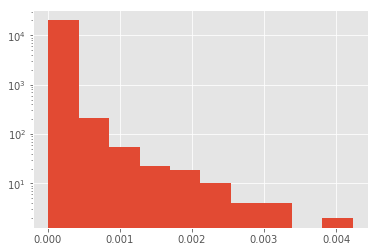

In [418]:
%matplotlib inline
val_clicks_cnt['pictures_cnt'].hist(log=True)

In [419]:
val_clicks_cnt['prob_pictures_cnt'] = val_clicks_cnt['pictures_cnt'].apply(bpdf)

# Делим пользователей для валидации

In [420]:
val_clicks_cnt_freq = val_clicks_cnt['prob_pictures_cnt'].value_counts()
val_clicks_cnt_freq = val_clicks_cnt_freq[val_clicks_cnt_freq >= 2]

In [421]:
val_clicks_cnt_users_dict = val_clicks_cnt.groupby(['prob_pictures_cnt'])['user_id'].apply(list).to_dict()

In [422]:
# good_users = [user for user in good_users if user not in test_users]
# weights = np.array([val_holdout_cnt['sum'][user] for user in good_users])
# weights = weights / np.sum(weights)

# good_users = np.random.choice(
#     good_users, 
#     size=min(len(good_users), int(users_cnt)), 
#     replace=False, 
#     p=weights
# ).tolist()

##### Пытаемся сгенерировать похожие на тест распределения для валидации

In [423]:
int(prob / val_clicks_cnt_freq.max() * users_cnt)

0

In [424]:
np.random.seed(RANDOM_STATE)

val_one_users = []
val_two_users = []

for prob, users_cnt in val_clicks_cnt_freq.iteritems():
    p_users_cnt = int(prob / val_clicks_cnt_freq.index.max()   * users_cnt)
    users_sample_cnt = int(p_users_cnt / 2)
    
    if users_sample_cnt < 1:
        continue
        
    print(users_cnt, p_users_cnt, prob / val_clicks_cnt_freq.max())
    
    _users = val_clicks_cnt_users_dict[prob]
    _selected_users = np.random.choice(
        _users, 
        size=users_sample_cnt,
        replace=False
    )
    val_one_users.extend(_selected_users)
    
    _users = list(set(_users) - set(_selected_users))
    _selected_users = np.random.choice(
        _users, 
        size=users_sample_cnt,
        replace=False
    )
    val_two_users.extend(_selected_users)
    
#     print(prob, val, users_sample_cnt)
    
assert len(set(val_one_users) & set(val_two_users)) == 0
assert len(val_one_users) == len(val_two_users)

7669 7154 0.7619351512398275
3819 3819 0.8167580921539708
2058 1940 0.7702631107164697
1315 1123 0.6979059444980321
919 703 0.62483676830188
647 442 0.5586040656560336
545 334 0.5007588706504967
473 261 0.4508722591158883
340 169 0.4079538716058669
264 119 0.37095138317451043
233 96 0.33891431936785943
186 65 0.28663938922749554
184 70 0.31103401757421845
133 43 0.2651789438484063
130 39 0.24620056605825402
108 28 0.21427067017604864
104 29 0.22933307533247835
83 19 0.1885912771374767
81 19 0.20076025446767473
73 15 0.1775876414887697
61 11 0.15019846048948512
60 12 0.16760127302208783
51 9 0.1585069990900336
45 7 0.14258483383690715
39 6 0.13558819181987303
37 5 0.11767218465180387
36 5 0.12914136673746637
36 5 0.12318621265524114
33 3 0.09535060470873605
33 4 0.11255517148903268
31 4 0.10779653180169746
27 3 0.09922249252480678
26 2 0.0851195555825126
25 2 0.08831897650061953
23 2 0.09172308702886102
23 2 0.08210806661157312
20 2 0.10336229452768694


In [425]:
all_val_users = set(val_one_users) | set(val_two_users)
len(all_val_users)

16550

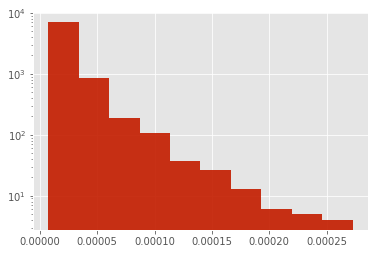

In [426]:
# val_clicks_cnt['pictures_cnt'].hist(log=True, alpha=0.7, color='blue', bins=10)
# test_clicks_cnt['pictures_cnt'].hist(log=True, alpha=0.7, color='gray', bins=10)
val_clicks_cnt[val_clicks_cnt['user_id'].isin(val_one_users)]['pictures_cnt'].hist(log=True, alpha=0.7, color='g')
val_clicks_cnt[val_clicks_cnt['user_id'].isin(val_two_users)]['pictures_cnt'].hist(log=True, alpha=0.7, color='r')

### Обогащаем трейн

In [448]:
val_train_clicks = train_clicks.query("user_id in @all_val_users")
val_train_likes = train_likes.query("user_id in @all_val_users")
val_train_shares = train_shares.query("user_id in @all_val_users")

not_val_data_clicks = data_clicks.query("user_id not in @all_val_users")
not_val_data_likes = data_likes.query("user_id not in @all_val_users")
not_val_data_shares = data_shares.query("user_id not in @all_val_users")

In [450]:
enriched_train_clicks = pd.concat([not_val_data_clicks, val_train_clicks], ignore_index=True)
enriched_train_likes = pd.concat([not_val_data_likes, val_train_likes], ignore_index=True)
enriched_train_shares = pd.concat([not_val_data_shares, val_train_shares], ignore_index=True)

In [454]:
enriched_train_clicks.to_hdf(os.path.join(DATA_PATH, 'step1_enriched_train_clicks.h5'), index=None, key='step1')
enriched_train_likes.to_hdf(os.path.join(DATA_PATH, 'step1_enriched_train_likes.h5'), index=None, key='step1')
enriched_train_shares.to_hdf(os.path.join(DATA_PATH, 'step1_enriched_train_shares.h5'), index=None, key='step1')

### Сохраняем пользователей

In [437]:
import json

with open(os.path.join(DATA_PATH, 'val1_users.json'), 'w') as f:
    json.dump({'users': list(map(int, val_one_users))}, f)
    
with open(os.path.join(DATA_PATH, 'val2_users.json'), 'w') as f:
    json.dump({'users': list(map(int, val_two_users))}, f)

In [456]:
!ls -alh data

total 370M
drwxrwxrwx 1 root root  424 Jun  1 14:49 .
drwxrwxrwx 1 root root 4.0K Jun  1 14:48 ..
-rwxrwxrwx 1 root root   53 Jun  1 11:12 desc_mapping.csv
-rwxrwxrwx 1 root root 109M Jun  1 11:11 step0_clicks.h5
-rwxrwxrwx 1 root root  15M Jun  1 11:28 step0_likes.h5
-rwxrwxrwx 1 root root 2.3M Jun  1 11:11 step0_shares.h5
-rwxrwxrwx 1 root root 106M Jun  1 14:48 step1_enriched_train_clicks.h5
-rwxrwxrwx 1 root root  14M Jun  1 14:48 step1_enriched_train_likes.h5
-rwxrwxrwx 1 root root 2.2M Jun  1 14:48 step1_enriched_train_shares.h5
-rwxrwxrwx 1 root root  97M Jun  1 14:49 step1_train_clicks.h5
-rwxrwxrwx 1 root root  13M Jun  1 14:49 step1_train_likes.h5
-rwxrwxrwx 1 root root 2.1M Jun  1 14:49 step1_train_shares.h5
-rwxrwxrwx 1 root root 6.3M Jun  1 14:17 step1_val_clicks.h5
-rwxrwxrwx 1 root root 5.8M Jun  1 11:12 user_mapping.csv
-rwxrwxrwx 1 root root  63K Jun  1 14:26 val1_users.json
-rwxrwxrwx 1 root root  63K Jun  1 14:26 val2_users.json
